In [2]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False, dropout=0
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


In [3]:
class ResUnet(nn.Module):
    def __init__(
        self, 
        in_channels=1,
        out_channels=1,
        n_feat = 256, 
        dropout=0.1
        ):
        super(ResUnet, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_feat = n_feat

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True, dropout=dropout)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(2), nn.GELU())

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 2, 2), 
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        ) # resize to b*n*7*7

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.out_channels, 3, 1, 1),
        )

    def forward(self, x_c):
        x_c = self.init_conv(x_c)
        down1 = self.down1(x_c)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(up1, down2)  # add and multiply embeddings
        up3 = self.up2(up2, down1)
        out = self.out(torch.cat((up3, x_c), 1))
        return out

class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


In [4]:
data_root_path = "/root/autodl-tmp/STA_USA_precip/"

In [5]:
from datetime import datetime, timedelta
from dataset import random_sample_fixed
import torch, random, netCDF4

start_date = datetime(2014, 1, 1)
end_date = datetime(2018, 12, 31)
current_date = start_date
date_list = []

while current_date <= end_date:
    date_list.append(current_date.strftime("%Y%m%d"))
    current_date += timedelta(days=1)

condition = {}
prism = {}
for current_date in tqdm(date_list):
    # condition
    path_meteo = r'/dynamical_input/meteo_%s.nc' % current_date
    v_meteo = netCDF4.Dataset(data_root_path + path_meteo).variables['data'][:].data
    path_t2m = r'/T2M/t2m_%s.nc' % current_date
    t2m_1d = netCDF4.Dataset(data_root_path + path_t2m).variables['data'][:].data
    condition[current_date] = np.concatenate((v_meteo[:-24*3], t2m_1d), axis=0)

    # precip
    path_pr_sr = r'/pr_sr_nc/pr_sr_%s.nc' % current_date
    pr_sr = netCDF4.Dataset(data_root_path + path_pr_sr).variables['data'][:].data
    pr_sr[pr_sr==-9999] = np.nan
    pr_sr[np.isnan(pr_sr)] = 0
    prism[current_date] = pr_sr

condition['h'] = netCDF4.Dataset(data_root_path + r'/usa_dem.nc').variables['data'][:].data

data_list = [date for date in date_list for _ in range(10)]
random.shuffle(data_list)
data_len = len(data_list)
train_data_list = data_list[:int(data_len*0.9)]
val_data_list = data_list[int(data_len*0.9):int(data_len)]

  0%|          | 2/1826 [00:00<03:12,  9.46it/s]

100%|██████████| 1826/1826 [02:51<00:00, 10.62it/s]


In [6]:
from torch.utils.data import DataLoader, Dataset
class dicDataset(Dataset):
    def __init__(self, data_list, batch_size=64):
        self.data_list = data_list
        self.batch_size = batch_size
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index):
        random_x, random_y = random.random(), random.random()
        data = random_sample_fixed(prism[self.data_list[index]], (192, 192), random_x, random_y)
        pr_transformed = torch.from_numpy(data)
        pr_transformed = torch.log(pr_transformed + 1).unsqueeze(0)
        
        condition_day = condition[self.data_list[index]]
        condition_day_sampled = random_sample_fixed(condition_day, 
                                                              (48, 48), random_x, random_y)
        condition_dem_sampled = random_sample_fixed(condition['h'], 
                                                              (48, 48), random_x, random_y)
        condition_dem_sampled = condition_dem_sampled[np.newaxis, :, :]
        condition_sampled = np.concatenate((condition_day_sampled, condition_dem_sampled), axis=0)

        return {'pr':pr_transformed, 'condition':torch.from_numpy(condition_sampled)}

In [7]:
train_dataset =dicDataset(train_data_list[:])
val_dataset = dicDataset(val_data_list[:])
batch_size = 32
# num_workers=8
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                    shuffle=True, pin_memory=True) # , num_workers=num_workers
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size,
                    shuffle=True, pin_memory=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
from vae_precip import VAE
num_variables = 1
num_hiddens = 256 
num_residual_layers = 2 
num_residual_hiddens = 48  
embedding_dim = 4 
vae = VAE(num_variables, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 embedding_dim).to(device)
vae.load_state_dict(torch.load(r'/root/autodl-tmp/model_save/UNet_of_SDM/' + 'vae_precip.pt')['model_state_dict'])
vae.eval()

VAE(
  (encoder): Encoder(
    (_conv_1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(256, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(48, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (_pre_vq_conv): Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))
  (decoder): Decoder(
    (_conv_1): Conv2d(4, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
           

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_feat = 1024
lrate = 1e-4
train_loss_list, val_loss_list = [], []

UNet = ResUnet(in_channels=385, out_channels=4, n_feat=n_feat, dropout=0.1)
UNet.to(device)
optG = torch.optim.Adam(UNet.parameters(), lr=lrate)

In [11]:
train_loss_list, val_loss_list = [], []
patience = 20 
counter = 0 
model_root_path = '/root/autodl-tmp/model_save/UNet_of_SDM/'
best_train_path = model_root_path + 'UNet_best_train.pt'


In [12]:
import os
load_path = model_root_path + 'UNet_gen.pt'
load_path_train = model_root_path + 'UNet_best_train.pt'
if os.path.exists(load_path):
    print('Loading model from {}'.format(load_path))
    checkpoint = torch.load(load_path)
    UNet.load_state_dict(checkpoint['model_state_dict'])
    optG.load_state_dict(checkpoint['optimizer_state_dict'])
elif os.path.exists(load_path_train):
    print('Loading model from {}'.format(load_path_train))
    checkpoint = torch.load(load_path_train)
    UNet.load_state_dict(checkpoint['model_state_dict'])
    optG.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    print('the first time to train')

Loading model from /root/autodl-tmp/model_save/UNet_of_SDM/UNet_gen.pt


In [13]:
from tqdm import tqdm
best_val_loss = float('inf') 
n_epoch = 200

pbar = tqdm(range(n_epoch))
for epoch in pbar:
    # print(epoch)
    epoch_loss_list = []
    UNet.train()
    # linear lrate decay
    optG.param_groups[0]['lr'] = lrate*(1-epoch/(n_epoch+1))/2
    # pbar = tqdm(train_dataloader)
    for dictdata in train_dataloader:
        optG.zero_grad()
        precip_sr = dictdata['pr'].to(device)
        z = vae.encoder(precip_sr)
        z = vae._pre_vq_conv(z)
        x_c = dictdata['condition'].to(device)
        out = UNet(x_c)
        loss = nn.MSELoss()(z, out)
        loss.backward()
        # pbar.set_description(f"train loss: {loss.item():.4f}")
        epoch_loss_list.append(loss.item())
        # torch.nn.utils.clip_grad_norm_(UNet.parameters(), max_norm=1.0)
        optG.step()
    train_mean_loss = np.mean(epoch_loss_list)
    train_loss_list.append(train_mean_loss)
    if (epoch+1) % 10 == 0:
        np.savetxt("UNet_con_train_loss.txt", np.array(train_loss_list), fmt='%.8f')

    # val
    epoch_loss_list = []
    UNet.eval()
    with torch.no_grad():
        # pbar1 = tqdm(val_dataloader)
        for dictdata in val_dataloader:
            precip_sr = dictdata['pr'].to(device)
            z = vae.encoder(precip_sr)
            z = vae._pre_vq_conv(z)
            x_c = dictdata['condition'].to(device)
            out = UNet(x_c)
            loss = nn.MSELoss()(z, out)
            # pbar1.set_description(f"val loss: {loss.item():.4f}")
            epoch_loss_list.append(loss.item())

    val_mean_loss = np.mean(epoch_loss_list)
    val_loss_list.append(val_mean_loss)
    pbar.set_description(f"train loss: {train_mean_loss:.4f}; val loss: {val_mean_loss:.4f}")

    if (epoch+1) % 10 == 0:
        np.savetxt("UNet_con_val_loss.txt", np.array(val_loss_list), fmt='%.8f')
        
    if val_mean_loss < best_val_loss:
        best_val_loss = val_mean_loss
        counter = 0
        state_dict = UNet.state_dict()
        optimizer_state_dict = optG.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save({
            'model_state_dict': state_dict,
            'optimizer_state_dict': optimizer_state_dict,}, best_train_path)
    else:
        counter += 1

    if (epoch+1) % 25:
        state_dict = UNet.state_dict()
        optimizer_state_dict = optG.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save({
            'model_state_dict': state_dict,
            'optimizer_state_dict': optimizer_state_dict,}, best_train_path)

    # 判断是否达到早停条件
    if counter >= patience:
        print("No improvement in validation loss for {} epochs.".format(patience))


train loss: 0.0079; val loss: 0.0076:  18%|█▊        | 35/200 [4:46:43<22:31:43, 491.54s/it]


KeyboardInterrupt: 

In [14]:
gen_path = model_root_path + 'UNet_gen.pt'
# gen
state_dict = UNet.state_dict()
optimizer_state_dict = optG.state_dict()
for key, param in state_dict.items():
    state_dict[key] = param.cpu()
torch.save({
    'model_state_dict': state_dict,
    'optimizer_state_dict': optimizer_state_dict,}, gen_path)

In [15]:
gen_path = model_root_path + 'UNet_con.pt'
# gen
state_dict = UNet.state_dict()
for key, param in state_dict.items():
    state_dict[key] = param.cpu()
torch.save({
    'model_state_dict': state_dict,}, gen_path)

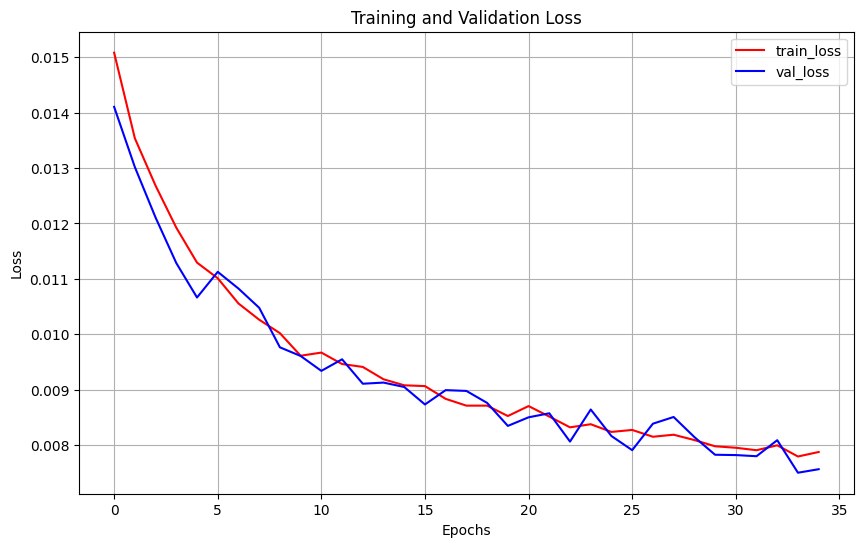

In [16]:
import matplotlib.pyplot as plt

train_loss = train_loss_list # list(np.loadtxt('train_loss.txt'))
val_loss = val_loss_list # list(np.loadtxt('val_loss.txt'))
x = range(len(val_loss_list))

plt.figure(figsize=(10, 6))

plt.plot(x, train_loss, color='red', label='train_loss')

plt.plot(x, val_loss, color='blue', label='val_loss')

plt.legend()

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.grid(True)

plt.show()